In [3]:
import pandas as pd
import numpy as np
import torch
from pandas.core.nanops import nanmax
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler,LabelEncoder
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, confusion_matrix, classification_report
from sklearn.preprocessing import LabelEncoder

def label_encode_except_zero(col, col_name):
    # 创建一个新的列副本
    new_col = col.copy()

    # 选择非 0 的值进行 label encoding
    mask = new_col != 0
    non_zero_values = new_col[mask]

    # 使用 LabelEncoder 对非 0 值进行编码
    le = LabelEncoder()
    new_col[mask] = le.fit_transform(non_zero_values) + 1  # 从1开始

    label_mappings[col_name] = dict(zip(le.classes_, le.transform(le.classes_) + 1))

    return new_col

def process_deal_period(deal_period_col):
    # 将 -1 替换为 91，表示没有成交
    deal_period_col = deal_period_col.replace(-1, 91)
    # 返回处理后的列
    return deal_period_col
# 针对单个样本，输出影响最大的3个特征
def get_top_influential_features_for_sample(model, sample, feature_names, top_n=3):
    """
    获取单个样本影响最大的正向和负向特征。

    参数:
    - model: 训练好的逻辑回归模型
    - sample: 单个样本（1D数组或Series），标准化后的输入
    - feature_names: 特征名称的列表
    - top_n: 输出的影响最大的正向和负向特征数量

    返回:
    - top_positive_features: 影响最大的正向特征
    - top_negative_features: 影响最大的负向特征
    """
    # 获取模型的系数
    feature_importance = model.coef_[0]

    # 计算每个特征对该样本的贡献值
    contributions = sample * feature_importance

    # 创建特征贡献值的DataFrame
    contributions_df = pd.DataFrame({
        'Feature': feature_names,
        'Contribution': contributions
    })

    # 筛选正向影响的特征并按贡献值排序
    top_positive_features = contributions_df[contributions_df['Contribution'] > 0]
    top_positive_features = top_positive_features.sort_values(by='Contribution', ascending=False).head(top_n)

    # 筛选负向影响的特征并按贡献值绝对值排序
    top_negative_features = contributions_df[contributions_df['Contribution'] < 0]
    top_negative_features = top_negative_features.sort_values(by='Contribution', ascending=True).head(top_n)

    return top_positive_features, top_negative_features

def evaluate_model(Y, Y_pred):

    accuracy = accuracy_score(Y, Y_pred)
    precision = precision_score(Y, Y_pred)
    recall = recall_score(Y, Y_pred)  # 控制recall 提高精度
    f1 = f1_score(Y, Y_pred)
    roc_auc = roc_auc_score(Y, Y_pred_prob)

    print(f'Accuracy: {accuracy:.4f}')
    print(f'Precision: {precision:.4f}')
    print(f'Recall: {recall:.4f}')
    print(f'F1 Score: {f1:.4f}')
    print(f'ROC AUC Score: {roc_auc:.4f}')

def get_top_influential_features_for_model(model, feature_names, top_n=5):
        """
        获取模型中权重最大的正向和负向特征。

        参数:
        - model: 训练好的逻辑回归模型
        - feature_names: 特征名称的列表
        - top_n: 输出的影响最大的正向和负向特征数量

        返回:
        - top_positive_features: 权重最大的正向特征及其权重
        - top_negative_features: 权重最大的负向特征及其权重
        """
        # 获取模型的系数
        feature_importance = model.coef_[0]

        # 创建包含特征名和对应权重的DataFrame
        feature_df = pd.DataFrame({
            'Feature': feature_names,
            'Weight': feature_importance
        })

        # 筛选正向影响的特征并按权重排序
        top_positive_features = feature_df[feature_df['Weight'] > 0]
        top_positive_features = top_positive_features.sort_values(by='Weight', ascending=False)

        # 筛选负向影响的特征并按权重排序
        top_negative_features = feature_df[feature_df['Weight'] < 0]
        top_negative_features = top_negative_features.sort_values(by='Weight', ascending=True)

        return top_positive_features, top_negative_features

def process_days_since(df,column_name):
    fixed_date = pd.to_datetime("2024-01-01")
    # 计算日期差值，超过8000天或为空时设置为-1
    days_since = (fixed_date - pd.to_datetime(df[column_name], errors='coerce')).dt.days
    return days_since.where(days_since <= 8000, -1).fillna(-1)

def compute_feature_difference(df, feature1, feature2):
    """
    计算两个特征列的差值，并将结果存储在新列中。

    参数:
    - df: DataFrame
    - feature1: 第一个特征列的名称
    - feature2: 第二个特征列的名称

    返回:
    - DataFrame，包含计算后的新差值列
    """
    # 将两个特征列转换为数值类型，非数值项将被转换为 NaN
    df[feature1] = pd.to_numeric(df[feature1], errors='coerce').fillna(0)
    df[feature2] = pd.to_numeric(df[feature2], errors='coerce').fillna(0)
    return df[feature1] - df[feature2]

In [4]:
df_original_deal = pd.read_csv("deal.csv")
df_original_nodeal = pd.read_csv("nodeal.csv")
print(df_original_deal.head)

C:\Users\10928\AppData\Local\Temp\ipykernel_182924\3528048524.py:1: DtypeWarning: Columns (12,13,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original_deal = pd.read_csv("deal.csv")


<bound method NDFrame.head of        patient_id                             tenant_id  opportunity_id  \
0         1000150  721a78d1-97a3-41cf-b4ff-328baf228b38              -1   
1         1000150  721a78d1-97a3-41cf-b4ff-328baf228b38              -1   
2         1000151  cf2d598a-c78a-40c5-b43d-8cc56594f3df              -1   
3         1000297  cf2d598a-c78a-40c5-b43d-8cc56594f3df              -1   
4         1000297  cf2d598a-c78a-40c5-b43d-8cc56594f3df              -1   
...           ...                                   ...             ...   
67209      999952  3dcbc5e8-2d0a-4a32-b85a-c846c01eab87              -1   
67210      999952  3dcbc5e8-2d0a-4a32-b85a-c846c01eab87              -1   
67211      999952  3dcbc5e8-2d0a-4a32-b85a-c846c01eab87              -1   
67212      999952  3dcbc5e8-2d0a-4a32-b85a-c846c01eab87              -1   
67213      999952  3dcbc5e8-2d0a-4a32-b85a-c846c01eab87              -1   

       instance_id                                         tooth_code

C:\Users\10928\AppData\Local\Temp\ipykernel_182924\3528048524.py:2: DtypeWarning: Columns (12,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_original_nodeal = pd.read_csv("nodeal.csv")


In [5]:
#-------------------------------------------------------
# 查看成交数量
num_deals = len(df_original_deal)
print(f"成交数量: {num_deals}")

# 查看未成交数量
num_nodeals = len(df_original_nodeal)
print(f"未成交数量: {num_nodeals}")

#-------------------------------------------------
df_combined = pd.concat([df_original_deal, df_original_nodeal], ignore_index=True)
df_combined = df_combined.sample(frac=1, random_state=42).reset_index(drop=True)
#-----------------------------
df_combined['days_since_last_consume'] = process_days_since(df_combined, 'last_consume_datetime')
df_combined['days_since_last_deal'] = process_days_since(df_combined, 'last_deal_datetime')
df_combined['days_since_opportunity_created'] = process_days_since(df_combined, 'opportunity_create_time')

df_combined['office_deal_consume_amount_diff'] = df_combined['office_deal_amount'] - df_combined['office_consume_amount']
df_combined['office_deal_consume_item_super_count_diff']=compute_feature_difference(df_combined,"office_deal_item_super_type_count","office_consume_item_super_type_count")
df_combined['office_deal_consume_chargeitem_count_diff']=compute_feature_difference(df_combined,"office_deal_chargeitem_count","office_consume_chargeitem_count")


saved_feature_names = df_combined.columns.tolist()
label_mappings = {}


# df_delete = df_combined.drop(columns=['tooth_code','observation_opportunity','birthday','constellation','refereename','occupation','homeaddress','marriage',
#                                       'family_mumber_count','companyname','first_arrive_date','last_consume_datetime','last_deal_datetime','opportunity_create_time','observation_accuracy_rate',
#                                       'is_chief_complaint','is_in_medical','snapshot_date','pay_datetime','lastupdateddt',
#                                       'age',
#                                       'office_consume_amount','office_consume_item_super_type_count','office_consume_chargeitem_count'])
df_unfiltered = df_combined.replace([pd.NaT, None, 'NA'], np.nan)
df_unfiltered.fillna(0, inplace=True)
#---delete empty value > 0.6 samples-----------
# df_drop_sample = df_unfiltered.drop(columns=['patient_id','tenant_id','opportunity_id','treatmentadvice_code','observation_name',
#                                              'address','city','city_tier','refer_patient_count','opening_days','patient_count','cashflow_level',"instance_id"])

df_drop_sample = df_unfiltered.drop(columns=['patient_id','tenant_id','opportunity_id','treatmentadvice_code','observation_name',"birthday","occupation",
                                             'address','city','city_tier','refer_patient_count','opening_days','patient_count','cashflow_level',"instance_id",
                                             "homeaddress", "marriage", "family_mumber_count", "companyname",
                                             "first_arrive_date", "observation_name", "sex",
                                             "office_consume_item_type_count","age",
                                             "office_deal_item_type_count", "observation_accuracy_rate",
                                             "is_in_medical", "last_consume_datetime", "last_deal_datetime",
                                             "city_tier", "cashflow_level", "snapshot_date",
                                             "pay_datetime", "lastupdateddt", "opportunity_create_time"
                                             ])
df_drop_sample['zero_rate'] = (df_drop_sample == 0).mean(axis=1)
# 从df_drop_sample中筛选出zero_rate小于等于0.7的样本索引
valid_indices = df_drop_sample[df_drop_sample['zero_rate'] <= 0.6].index
# 根据索引从df_unfiltered中提取对应的样本
df = df_unfiltered.loc[valid_indices].reset_index(drop=True)

# 指定要编码的列
columns_to_encode = ['observation_name','address','city','city_tier']

# 对指定列进行编码
for col in columns_to_encode:
    df[col] = label_encode_except_zero(df[col], col)
# 将特征 "deal_period" 应用处理
df['order_deal_period'] = process_deal_period(df['order_deal_period'])

# #------做权重调整-----------
# 需要降低权重的特征
low_weight_features = ['patient_count','address']
# 对这些特征进行缩放，降低权重
scaling_factor = 0.01  # 可以根据需要调整缩放因子
df[low_weight_features] = df[low_weight_features].astype(float) * scaling_factor
#----
# 需要降低权重的特征
low_weight_features_2 = ['refer_patient_count','opening_days']
# 对这些特征进行缩放，降低权重
scaling_factor_2 = 0.1  # 可以根据需要调整缩放因子
df[low_weight_features_2] = df[low_weight_features_2].astype(float) * scaling_factor_2
#---
low_weight_features_3 = ['city']
# 对这些特征进行缩放，降低权重
scaling_factor_3 = 0.6  # 可以根据需要调整缩放因子
df[low_weight_features_3] = df[low_weight_features_3].astype(float) * scaling_factor_3

# #--------------------------
# # 选择除 'patient_id', 'tenant_id', 'is_deal_after_appointment' 之外的所有列作为特征
# X = df.drop(columns=["patient_id", "tenant_id", "opportunity_id", "treatmentadvice_code", "is_deal_after_appointment","order_deal_period","instance_id"])

X = df.drop(columns=["patient_id", "tenant_id", "opportunity_id", "treatmentadvice_code", "is_deal_after_appointment","order_deal_period","instance_id","tooth_code","observation_opportunity",
                     "birthday","constellation","refereename","occupation","homeaddress","marriage","family_mumber_count","companyname","first_arrive_date","observation_name","sex","office_consume_item_type_count",
                     "office_deal_item_type_count","observation_accuracy_rate","is_in_medical","last_consume_datetime","last_deal_datetime","city_tier","cashflow_level","snapshot_date","age",
                     "pay_datetime","lastupdateddt","opportunity_create_time"])
# print(X.columns)
# print(X.dtypes)
# 选择 'is_deal_after_appointment' 作为目标变量
Y = df['is_deal_after_appointment']
# 查看 0 和 1 的数量
counts = Y.value_counts()
print("is_deal_after_appointment 的数量分布:")
print(counts)
# 查看比例
percentages = Y.value_counts(normalize=True) * 100
print("\nis_deal_after_appointment 的比例分布:")
print(percentages)



# 标准化特征
scaler = StandardScaler()

成交数量: 67214
未成交数量: 65000
is_deal_after_appointment 的数量分布:
is_deal_after_appointment
1    33986
0    33061
Name: count, dtype: int64

is_deal_after_appointment 的比例分布:
is_deal_after_appointment
1    50.689815
0    49.310185
Name: proportion, dtype: float64


In [11]:
X_scaled = scaler.fit_transform(X)
# 在拆分前保存原始索引
indices = np.arange(X.shape[0])
# 拆分数据集
X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    X_scaled, Y, indices, test_size=0.2, random_state=42
)

# Save original indices
indices_balanced = df.index.to_numpy()
X_train, X_test, Y_train, Y_test, train_indices, test_indices = train_test_split(
    X_scaled, Y, indices_balanced, test_size=0.2, random_state=42, stratify=Y
)
#----------------
# 训练逻辑回归模型
from catboost import CatBoostClassifier
# model = LogisticRegression(class_weight='balanced',penalty='l2', C=1.5)
model = CatBoostClassifier(verbose=0)
model.fit(X_train, Y_train)

# 预测
Y_pred = model.predict(X_test)
Y_train_pred = model.predict(X_train)
# 预测成交概率
Y_pred_prob = model.predict_proba(X_test)[:, 1]


In [12]:
test_accuracy = accuracy_score(Y_test, Y_pred)
test_precision = precision_score(Y_test, Y_pred)
test_recall = recall_score(Y_test, Y_pred)# 控制recall 提高精度
test_f1 = f1_score(Y_test, Y_pred)

train_accuracy = accuracy_score(Y_train, Y_train_pred)
train_precision = precision_score(Y_train, Y_train_pred)
train_recall = recall_score(Y_train, Y_train_pred)# 控制recall 提高精度
train_f1 = f1_score(Y_train, Y_train_pred)

print(f'Accuracy: {test_accuracy:.4f}')
print(f'Precision: {test_precision:.4f}')
print(f'Recall: {test_recall:.4f}')
print(f'F1 Score: {test_f1:.4f}')
#print(f'ROC AUC Score: {test_roc_auc:.4f}')

print(f'Accuracy: {train_accuracy:.4f}')
print(f'Precision: {train_precision:.4f}')
print(f'Recall: {train_recall:.4f}')
print(f'F1 Score: {train_f1:.4f}')

Accuracy: 0.9674
Precision: 0.9648
Recall: 0.9712
F1 Score: 0.9680
Accuracy: 0.9811
Precision: 0.9804
Recall: 0.9824
F1 Score: 0.9814


In [14]:
data = [
    [0.68175744, 0.67013943, 0.67436537, 0.68508291, 0.67628813, 0.68162394,
 0.70648652, 0.69169349, 0.66539924, 0.68934433, 0.65701459],
[0.93510013 ,0.93134548 ,0.9388864 , 0.93257211, 0.93377461 ,0.93370455,
 0.93574208, 0.93264704, 0.93503532, 0.93538559, 0.93909682],
[0.4084762 , 0.38701267 ,0.40659668, 0.3745883,  0.39670614, 0.40321616,
 0.40097003, 0.41280698 ,0.40063258 ,0.41629387, 0.40768536],
[0.61289063, 0.60843871, 0.59485594, 0.63825092, 0.60854707, 0.62707252,
 0.65464981 ,0.62454668 ,0.59318795, 0.6136877,  0.56136024]
]
data = np.array(data)
data_mean = np.mean(data, axis = 0)
print(data_mean)

[0.6595561  0.64923407 0.6536761  0.65762356 0.65382899 0.66140429
 0.67446211 0.66542355 0.64856377 0.66367787 0.64128925]


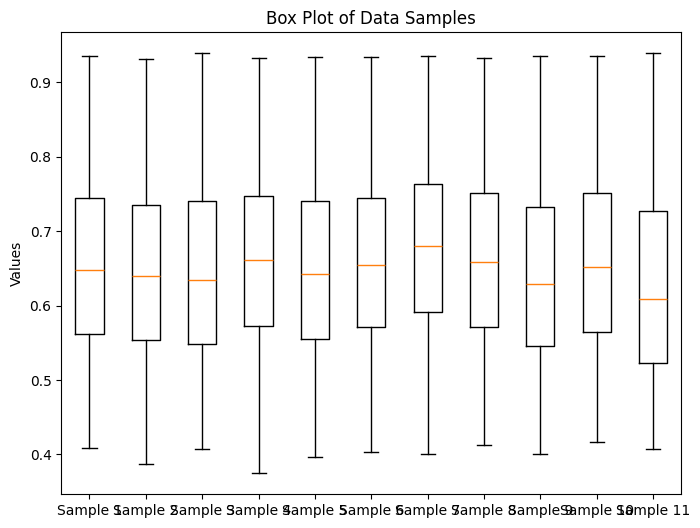

In [16]:
import numpy as np
import matplotlib.pyplot as plt

# 数据
data = [
    [0.68175744, 0.67013943, 0.67436537, 0.68508291, 0.67628813, 0.68162394,
     0.70648652, 0.69169349, 0.66539924, 0.68934433, 0.65701459],
    [0.93510013, 0.93134548, 0.9388864, 0.93257211, 0.93377461, 0.93370455,
     0.93574208, 0.93264704, 0.93503532, 0.93538559, 0.93909682],
    [0.4084762, 0.38701267, 0.40659668, 0.3745883, 0.39670614, 0.40321616,
     0.40097003, 0.41280698, 0.40063258, 0.41629387, 0.40768536],
    [0.61289063, 0.60843871, 0.59485594, 0.63825092, 0.60854707, 0.62707252,
     0.65464981, 0.62454668, 0.59318795, 0.6136877, 0.56136024]
]

# 转换为 numpy 数组
data = np.array(data)

# 绘制箱线图
plt.figure(figsize=(8, 6))
plt.boxplot(data)
plt.xticks(ticks=range(1, data.shape[1]+1), labels=[f'Sample {i+1}' for i in range(data.shape[1])])
plt.ylabel('Values')
plt.title('Box Plot of Data Samples')
plt.show()
